<a href="https://colab.research.google.com/github/rsglick/drl/blob/master/notebooks/LLCv2_stable_baselines3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Handle installs for Colab

In [1]:
import sys
IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:
    !apt-get install -y xvfb x11-utils python-opengl swig cmake ffmpeg freeglut3-dev
    !pip install Box2D box2d-py box2d-kengz gym[box2d] gym[Box_2D]
    !pip install pyvirtualdisplay PyOpenGL piglet piglet-templates PyOpenGL-accelerate
    !pip install stable-baselines3[extra]
    %matplotlib inline
else:
    %matplotlib inline
#     %matplotlib widget
#     %matplotlib notebook
#     %matplotlib notebook

# Load the TensorBoard notebook extension
%load_ext tensorboard

# Imports

In [2]:
import gym
import os
import matplotlib.pyplot as plt
import numpy as np
from tqdm.auto import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.distributions.categorical import Categorical
from torch.distributions.normal import Normal
from torch.utils.tensorboard import SummaryWriter


# Stable Baselines3 
#  https://github.com/DLR-RM/stable-baselines3
from stable_baselines3 import PPO, SAC, TD3, A2C

from stable_baselines3.common import results_plotter
from stable_baselines3.common.monitor import Monitor

from stable_baselines3.common.evaluation import evaluate_policy

from stable_baselines3.common.callbacks import BaseCallback
from stable_baselines3.common.callbacks import EvalCallback
from stable_baselines3.common.callbacks import StopTrainingOnRewardThreshold
from stable_baselines3.common.callbacks import CheckpointCallback
from stable_baselines3.common.callbacks import CallbackList

# Create Callbacks for monitoring training



In [3]:
class TensorboardCallback(BaseCallback):
    """
    Custom callback for plotting additional values in tensorboard.
    :param verbose: (int)
    """
    def __init__(self, log_dir, check_freq=1000, verbose=1, moving_average_window=100):
        super(TensorboardCallback, self).__init__(verbose)
        self.check_freq = check_freq
        self.log_dir = log_dir   
        self.moving_average_window = moving_average_window
        
    def _on_training_start(self):
        self.writer = SummaryWriter(log_dir=self.log_dir)      
        
    def _on_step(self):
        if self.num_timesteps % self.check_freq == 0:
            # Retrieve training reward
            x, y = results_plotter.ts2xy(results_plotter.load_results(self.log_dir), 'timesteps')
            if len(x) > 0:
                self.writer.add_scalar("charts/episode_reward", y[-1], self.num_timesteps)
            if len(x) > self.moving_average_window:
                moving_average = np.mean(y[-self.moving_average_window:])
                self.writer.add_scalar("charts/reward_moving_avg", moving_average, self.num_timesteps )
                
    def _on_training_end(self):
        """
        This event is triggered before exiting the `learn()` method.
        """
        self.writer.close()

        
class PlottingCallback(BaseCallback):
    """
    Callback for plotting the performance in realtime.

    :param verbose: (int)
    """
    def __init__(self, verbose=1):
        super(PlottingCallback, self).__init__(verbose)
        self._plot = None

    def _on_step(self) -> bool:
        # get the monitor's data
        x, y = results_plotter.ts2xy(results_plotter.load_results(log_dir), 'timesteps')
        if self._plot is None: # make the plot
            plt.ion()
            fig = plt.figure(figsize=(8,4))
            ax = fig.add_subplot(111)
            line, = ax.plot(x, y)
            self._plot = (line, ax, fig)
            plt.grid()
            plt.show()
        else: # update and rescale the plot
            self._plot[0].set_data(x, y)
            self._plot[-2].relim()
            self._plot[-2].set_xlim([self.locals["total_timesteps"] * -0.02, 
                                   self.locals["total_timesteps"] * 1.02])
            self._plot[-2].autoscale_view(True,True,True)
            self._plot[-1].canvas.draw()
            

class ProgressBarCallback(BaseCallback):
    """
    :param pbar: (tqdm.pbar) Progress bar object
    """
    def __init__(self, pbar):
        super(ProgressBarCallback, self).__init__()
        self._pbar = pbar

    def _on_step(self):
        # Update the progress bar:
        self._pbar.n = self.num_timesteps
        self._pbar.update(0)

# this callback uses the 'with' block, allowing for correct initialisation and destruction
class ProgressBarManager(object):
    def __init__(self, total_timesteps): # init object with total timesteps
        self.pbar = None
        self.total_timesteps = total_timesteps
        
    def __enter__(self): # create the progress bar and callback, return the callback
        self.pbar = tqdm(total=self.total_timesteps)
            
        return ProgressBarCallback(self.pbar)

    def __exit__(self, exc_type, exc_val, exc_tb): # close the callback
        self.pbar.n = self.total_timesteps
        self.pbar.update(0)
        self.pbar.close()


# Setup Environment

In [4]:
# LunarLanderContinuous-v2
# MountainCarContinuous-v0
# Pendulum-v0

env_name = "LunarLanderContinuous-v2"
env = gym.make(env_name)

# reward_threshold = -200 # For Pendulum-v0
reward_threshold = 300 # LunarLanderContinuous-v2
total_timesteps = 300000
callbackFreq = 1000

log_dir = f"./runs/{env_name}"
os.makedirs(log_dir, exist_ok=True)
env = Monitor(env, log_dir)


eval_env = gym.make(env_name)


In [5]:

tensorboard_callback =TensorboardCallback(log_dir=log_dir, 
                                          check_freq=callbackFreq)
plotting_callback = PlottingCallback()
reward_threshold_callback = StopTrainingOnRewardThreshold(reward_threshold=reward_threshold, 
                                                          verbose=1)
checkpoint_callback = CheckpointCallback(save_freq=callbackFreq, 
                                         save_path=log_dir)
eval_callback = EvalCallback(eval_env, 
                             render=False,
                             best_model_save_path=log_dir,
                             deterministic=True,
                             callback_on_new_best=reward_threshold_callback,
                             log_path=log_dir, 
                             verbose=1,
                             n_eval_episodes=5,
                             eval_freq=callbackFreq)

# Tensorboard
Set up Tensorboard to track traing visually. 

#TODO Provide more details in Tensorflow...

In [6]:
%tensorboard --logdir .

# SAC

In [7]:
# Hyperparams derived from the SAC paper
hidden_dims = 256
sac_hyperparams = {
    'learning_rate': 3.0e-4,
    'buffer_size': 1000000,
    'gamma': 0.99,
    'batch_size':256,
    'tau': 0.005,
    'device':'cuda',
    'seed':0,
    'target_entropy':"auto",
    'policy_kwargs':dict(net_arch=[hidden_dims, hidden_dims]),
}

# # https://github.com/openai/gym/wiki/Leaderboard#lunarlandercontinuous-v2
# hidden_dims = 64
# sac_hyperparams = {
#     'learning_rate': 5.0e-3,
#     'buffer_size': 200000,
#     'gamma': 0.999,
#     'batch_size':8192,
#     'tau': 0.005,
#     'device':'cuda',
#     'seed':0,
#     'target_entropy':"auto",
#     'policy_kwargs':dict(net_arch=[hidden_dims, hidden_dims]),
# }




modelSAC = SAC('MlpPolicy', 
               env,
               #verbose=1,
               **sac_hyperparams)

if os.path.exists(f"{log_dir}/modelSAC_{env_name}.zip"):
    print("Loading existing Model...")
    modelSAC = SAC.load(f"{log_dir}/modelSAC_{env_name}",
                       env=env)

Loading existing Model...


In [8]:
# Setup Tensorboard Graphs for some visualizations 

try:
    with SummaryWriter(f"{log_dir}/graphs/CriticQ1") as writer:
        dummy_input = (torch.zeros(1, 10))
        writer.add_graph(modelSAC.policy.critic.q1_net, input_to_model=dummy_input )

    with SummaryWriter(f"{log_dir}/graphs/CriticQ2") as writer:
        dummy_input = (torch.zeros(1, 10))
        writer.add_graph(modelSAC.policy.critic.q2_net, input_to_model=dummy_input )


    with SummaryWriter(f"{log_dir}/graphs/Actor_pi") as writer:
        dummy_input = (torch.zeros(1, 8))
        writer.add_graph(modelSAC.policy.actor.latent_pi, input_to_model=dummy_input )

    with SummaryWriter(f"{log_dir}/graphs/Actor_mu") as writer:
        dummy_input = (torch.zeros(1, hidden_dims))
        writer.add_graph(modelSAC.policy.actor.mu, input_to_model=dummy_input )

    with SummaryWriter(f"{log_dir}/graphs/Actor_log_std") as writer:
        dummy_input = (torch.zeros(1, hidden_dims))
        writer.add_graph(modelSAC.policy.actor.log_std, input_to_model=dummy_input )
except Exception as inst:
    print(f"ERROR: {inst}")
    print("Skipping Graphs")

# Training

In [9]:
%%time

with ProgressBarManager(total_timesteps) as progress_callback:
    callback = CallbackList([progress_callback,
                             #checkpoint_callback,
                             #plotting_callback,
                             tensorboard_callback,
                             eval_callback])
    modelSAC.learn(total_timesteps=total_timesteps, 
                   callback=callback,
                   )


# Save the agent
modelSAC.save(f"{log_dir}/modelSAC_{env_name}")
del modelSAC

Eval num_timesteps=1000, episode_reward=72.10 +/- 241.74
Episode length: 701.60 +/- 105.83
New best mean reward!
Eval num_timesteps=2000, episode_reward=-276.32 +/- 265.06
Episode length: 338.80 +/- 121.55
Eval num_timesteps=3000, episode_reward=119.21 +/- 113.54
Episode length: 495.60 +/- 204.04
New best mean reward!
Eval num_timesteps=4000, episode_reward=-281.54 +/- 292.86
Episode length: 221.00 +/- 67.67
Eval num_timesteps=5000, episode_reward=-136.21 +/- 99.39
Episode length: 138.00 +/- 20.66
Eval num_timesteps=6000, episode_reward=34.57 +/- 238.59
Episode length: 224.00 +/- 77.02
Eval num_timesteps=7000, episode_reward=160.27 +/- 199.16
Episode length: 237.80 +/- 21.16
New best mean reward!
Eval num_timesteps=8000, episode_reward=120.05 +/- 188.10
Episode length: 366.40 +/- 319.74
Eval num_timesteps=9000, episode_reward=213.91 +/- 92.74
Episode length: 355.80 +/- 205.58
New best mean reward!
Eval num_timesteps=10000, episode_reward=-146.88 +/- 146.83
Episode length: 339.80 +/- 34

# Evaluate Training

mean_reward 266.82 +/- 36.53
CPU times: user 5min 46s, sys: 12min 58s, total: 18min 44s
Wall time: 5min 51s


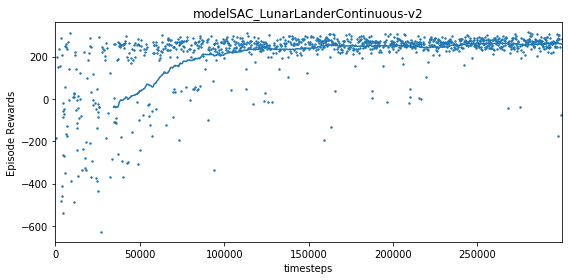

In [10]:
%%time

# Evaluate the trained agent
modelSAC = SAC.load(f"{log_dir}/modelSAC_{env_name}")


if os.stat(f"{log_dir}/monitor.csv").st_size > 100:
    results_plotter.plot_results(dirs=[log_dir], 
                                 num_timesteps=None,
                                 x_axis=results_plotter.X_TIMESTEPS, 
                                 task_name=f"modelSAC_{env_name}",
                                 figsize=(8,4)
                                )

# Evaluate the agent
mean_reward, std_reward = evaluate_policy(modelSAC, 
                                          eval_env, 
                                          render=False,
                                          n_eval_episodes=100)
eval_env.close()
print(f"mean_reward {mean_reward:.2f} +/- {std_reward:.2f}")

In [15]:
# Enjoy trained agent
def test_agent(model, 
               render: bool = False,
               timesteps: int = 1000000, 
               max_eps: int = 100,
               env_name: str = "LunarLanderContinuous-v2"):
    try:
        eval_env = gym.make(env_name)

        episode_rewards, episode_lengths = [], [] 
        episode_reward = 0.0
        episode_length = 0
        num_episodes   = 0
        obs = eval_env.reset()
        pbar = tqdm(total=timesteps)
        pbar_eps = tqdm(total=max_eps)
        #for i in tqdm(range(timesteps)):
        for i in range(timesteps):
            pbar.update()
            action, _states = model.predict(obs)
            obs, rewards, dones, info = eval_env.step(action)
            episode_reward += rewards
            episode_length += 1
            
            if render:
                eval_env.render()
            if dones:
                pbar_eps.update()
                num_episodes += 1
                pbar.write(f"Episode({num_episodes}) episode_reward = {episode_reward:.2f}, episode_length = {episode_length:.2f}")

                episode_rewards.append(episode_reward)
                episode_lengths.append(episode_length)

                episode_reward = 0.0
                episode_length = 0
                eval_env.reset()
                
                if num_episodes == max_eps:
                    break

            if i % 1000 == 0:
                pbar.write(f"Step {i}")
        pbar.refresh()
        pbar.close()
        pbar_eps.refresh()
        pbar_eps.close()
        eval_env.close()

        mean_reward = np.mean(episode_rewards)
        std_reward = np.std(episode_rewards)

        print(f"Total Eps({num_episodes}): mean_reward = {mean_reward:.2f} +/- {std_reward:.2f}")

    except KeyboardInterrupt:
        pbar.refresh()
        pbar.close()
        pbar_eps.refresh()
        pbar_eps.close()
        eval_env.close()
        return

test_agent(modelSAC, render=True)


Step 0
Episode(1) episode_reward = 245.55, episode_length = 174.00
Episode(2) episode_reward = 273.86, episode_length = 181.00
Episode(3) episode_reward = 247.42, episode_length = 147.00
Episode(4) episode_reward = 225.99, episode_length = 175.00
Episode(5) episode_reward = 310.23, episode_length = 193.00
Step 1000
Episode(6) episode_reward = 276.57, episode_length = 145.00
Episode(7) episode_reward = 292.63, episode_length = 448.00
Episode(8) episode_reward = 303.07, episode_length = 182.00
Episode(9) episode_reward = 233.76, episode_length = 237.00
Step 2000
Episode(10) episode_reward = 281.44, episode_length = 144.00
Episode(11) episode_reward = 259.11, episode_length = 172.00
Episode(12) episode_reward = 239.46, episode_length = 251.00
Step 3000
Episode(13) episode_reward = -156.40, episode_length = 1000.00
Episode(14) episode_reward = 274.44, episode_length = 176.00
Episode(15) episode_reward = 286.72, episode_length = 189.00
Episode(16) episode_reward = 247.93, episode_length = 1

# Record agents in action


In [16]:
# Set up fake display; otherwise rendering will fail
import os
os.system("Xvfb :1 -screen 0 1024x768x24 &")
os.environ['DISPLAY'] = ':1'

import base64
from pathlib import Path

from IPython import display as ipythondisplay

def show_videos(video_path='', prefix=''):
  """
  Taken from https://github.com/eleurent/highway-env

  :param video_path: (str) Path to the folder containing videos
  :param prefix: (str) Filter the video, showing only the only starting with this prefix
  """
  html = []
  for mp4 in Path(video_path).glob("{}*.mp4".format(prefix)):
      video_b64 = base64.b64encode(mp4.read_bytes())
      html.append('''<video alt="{}" autoplay 
                    loop controls style="height: 400px;">
                    <source src="data:video/mp4;base64,{}" type="video/mp4" />
                </video>'''.format(mp4, video_b64.decode('ascii')))
  ipythondisplay.display(ipythondisplay.HTML(data="<br>".join(html)))


from stable_baselines3.common.vec_env import VecVideoRecorder, DummyVecEnv

def record_video(env_id, model, video_length=500, prefix='', video_folder='videos/'):
  """
  :param env_id: (str)
  :param model: (RL model)
  :param video_length: (int)
  :param prefix: (str)
  :param video_folder: (str)
  """
  eval_env = DummyVecEnv([lambda: gym.make(env_id)])
  # Start the video at step=0 and record 500 steps
  eval_env = VecVideoRecorder(eval_env, video_folder=video_folder,
                              record_video_trigger=lambda step: step == 0, video_length=video_length,
                              name_prefix=prefix)

  obs = eval_env.reset()
  for _ in range(video_length):
    action, _ = model.predict(obs)
    obs, _, _, _ = eval_env.step(action)

  # Close the video recorder
  eval_env.close()

In [17]:
#video_folder = f"{env_name}_output"
video_folder = log_dir

# record_video(env_name, modelTD3, video_length=1000, prefix=f'td3_{env_name}', video_folder=video_folder)
# record_video(env_name, modelPPO, video_length=1000, prefix=f'ppo_{env_name}', video_folder=video_folder)
record_video(env_name, modelSAC, video_length=2000, prefix=f'sac_{env_name}', video_folder=log_dir)

Saving video to  /home/rsglick/Documents/python/drl/notebooks/runs/LunarLanderContinuous-v2/sac_LunarLanderContinuous-v2-step-0-to-step-2000.mp4


In [18]:
show_videos(log_dir, prefix=f'sac_{env_name}')